In [ ]:
!git clone https://github.com/bemc22/PnP-UA
%cd PnP-UA
!git clone https://github.com/cszn/DPIR
!pip install torch_dct
!curl https://r0k.us/graphics/kodak/kodak/kodim23.png -o kodim23.png

Cloning into 'PnP-UA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 45 (delta 13), reused 27 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 18.77 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/PnP-UA
Cloning into 'DPIR'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 239 (delta 48), reused 35 (delta 35), pack-reused 179
Receiving objects: 100% (239/239), 6.85 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (104/104), done.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x8

In [45]:
# libraries
import os
import sys
import torch

gpu_available = torch.cuda.is_available()
DEVICE = 'cuda' if gpu_available else 'cpu'
torch.set_default_tensor_type('torch.cuda.FloatTensor') if gpu_available else None

sys.path.append(os.path.join(os.getcwd(), 'DPIR'))

import cv2
import matplotlib.pyplot as plt

from libs.pnp import admm, deep_denoiser, modulo
from libs.utils import load_img

In [ ]:
# utilities functions
normalize  = lambda x: (x - torch.min(x,  dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]) / (torch.max(x, dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] - torch.min(x,  dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0])
tensor2img = lambda x: (x.permute(0, 2, 3, 1).squeeze().cpu().numpy() * 255).astype('uint8')
img2tensor = lambda x: torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
centering  = lambda x: x - torch.mean(x, dim=(-1, -2), keepdim=True)


In [ ]:
# load model online
from DPIR.models.network_unet import UNetRes as net

def load_model(model_name):
    model_path = os.path.join(".", model_name+'.pth')
    n_channels = 3
    model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
    model.load_state_dict(torch.load(model_path), strict=True)
    for k, v in model.named_parameters():
            v.requires_grad = False

    return model

model_url= 'https://huggingface.co/deepinv/drunet/resolve/main/drunet_color.pth?download=true'
torch.hub.download_url_to_file(model_url, "drunet_color.pth", hash_prefix=None, progress=True)

100%|██████████| 125M/125M [00:02<00:00, 60.7MB/s]


In [50]:
# image parameters
img_size           = 1024
wrapping_threshold = 64

# recovert parameters
max_iters = 5
epsilon   = 0.1
_lambda   = 0.1
gamma     = 1.1

In [57]:
# Load image
img_path  = os.path.join(".", "kodim23.png")
img       = load_img(img_path, img_size)
img_t     =  img2tensor(img) / wrapping_threshold

# Modulo operation
modulo_t  = modulo(img_t + torch.rand_like(img_t) * 0.1, 1.0).to(DEVICE)
img_t     = centering(img_t).to(DEVICE)

# Unwrapping
model_name = 'drunet_color'
model = load_model(model_name)
model = model.to(DEVICE)

img_est = admm(modulo_t, deep_denoiser, model, max_iters=max_iters, epsilon=epsilon, _lambda=_lambda, gamma=gamma)

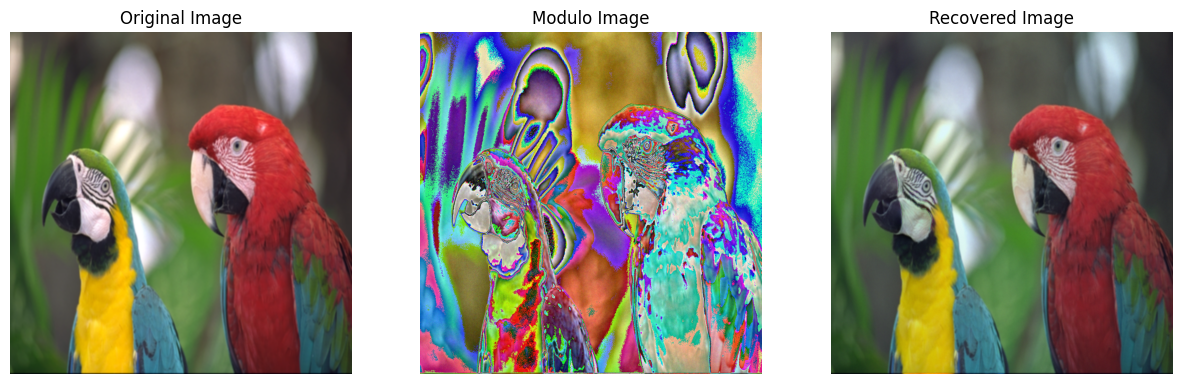

In [58]:
# Visualize
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow( tensor2img(normalize(img_t)) )
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow( tensor2img(normalize(modulo_t)) )
plt.title("Modulo Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow( tensor2img(normalize(img_est)) )
plt.title("Recovered Image")
plt.axis('off')

plt.show()